In [25]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from itertools import chain
from scipy.spatial.distance import cdist
import scipy as sp
import GPy
import safeopt
from SafeProblem import Problem

import matplotlib.pyplot as plt

def plot_function(x_1, x_2, y, safe_threshold):
    y_grid = y.reshape(len(x_1), len(x_2))
    # Plot function
    fig, ax = plt.subplots(figsize=(14, 8))
    cntr_f = ax.contourf(x_1, x_2, y_grid, levels=np.linspace(np.min(y), np.max(y), 50),
                         cmap=plt.cm.get_cmap('viridis').reversed())
    cntr_t = ax.contour(x_1, x_2, y_grid, levels=[safe_threshold], colors = "r", linewidths=2, linestyles="dashed")
    o, _ = cntr_t.legend_elements()
    legend_objs = [o[0]]
    legend_labels = ["Safety Threshold"]
    ax.legend(legend_objs, legend_labels)
    ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
    ax.axis('square')
    fig.colorbar(cntr_f)
    legend = [legend_objs, legend_labels]
    return fig, ax, legend

def plot_optimal(x_opt, fig, ax, legend):
    legend[0] += ax.plot(x_opt[0], x_opt[1], 'x', color='white', markersize=10)
    legend[1] += ["Optimal"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_safeopt(opt, fig, ax, legend):
    legend[0] += ax.plot(opt.parameter_set[opt.S,0], opt.parameter_set[opt.S,1], '.',  color='grey', markersize=5)
    legend[1] += ["Safe set"]
    legend[0] += ax.plot(opt.parameter_set[opt.M,0], opt.parameter_set[opt.M,1], '.', color='m', markersize=5)
    legend[1] += ["Maximizers set"]
    legend[0] += ax.plot(opt.parameter_set[opt.G,0], opt.parameter_set[opt.G,1], '.', color='red', markersize=5,alpha=0.9)
    legend[1] += ["Expanders set"]
    legend[0] += ax.plot(opt.x[:,0], opt.x[:,1], 'x', color='blue', markersize=10)
    legend[1] += ["Evaluated points"]
    return fig, ax, legend

def plot_safe_seed(x_safe_seed, fig, ax, legend):
    o = ax.plot(x_safe_seed[:,0], x_safe_seed[:,1], 'o', markersize=5, color='k')
    legend[0] += o
    legend[1] += ["Initial safe seed"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_all(fun, opt, x_safe_seed, x_optimal):
    fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, opt.fmin)
    fig, ax, legend = plot_safeopt(opt, fig, ax, legend)
    fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
    plot_optimal(x_optimal, fig, ax, legend)
 
# Objective function
# WARNING: GPy has issues with negative function values. The RBF kernel assumes the prior mean is zero. 
# Since zero is safe, SafeOpt gets very confused.
def sphere_broken(x): 
    x_opt = np.array([-1,-2])
    x = np.asarray(x) - x_opt
    #    return -((x*x).sum(axis=0))
    return -np.inner(x, x)

def sphere(x): return 100 + sphere_broken(x)

def rosenbrock(x):
    z = np.asarray(x)
    z = z + 1
    b = 100
    r = np.sum(b * (z[1:] - z[:-1]**2.0)**2.0 + (1 - z[:-1])**2.0, axis=0)
    r = 100 - np.log(r) # We take the log reduce the gradient and get a smaller lipschitz
    return r

safe_sphere = Problem(fun = sphere, bounds = [(-5., 5.),(-5., 5.)], percentile = 0.75,
                     default_safe_seeds = [18643, 118129,  18766, 101797,  64078,  63071, 108293,  19281,  29693, 125759])
#safe_sphere = Problem(fun = sphere, bounds = [(-5., 5.),(-8., 2.)], percentile = 0.75,
#                     default_safe_seeds = [86225, 199784,  86241, 180581, 137070, 136068, 188095,  86672,  96619, 209639])
#safe_rosenbrok = Problem(fun = rosenbrock, bounds = [(-3., 3.),(-3.,3.)], percentile = 0.5)
fun = safe_sphere

Safe Threshold (0.75) = 92.01246179734218


y_opt = 99.99989959879679, x_opt = [-0.99198397 -1.99398798]


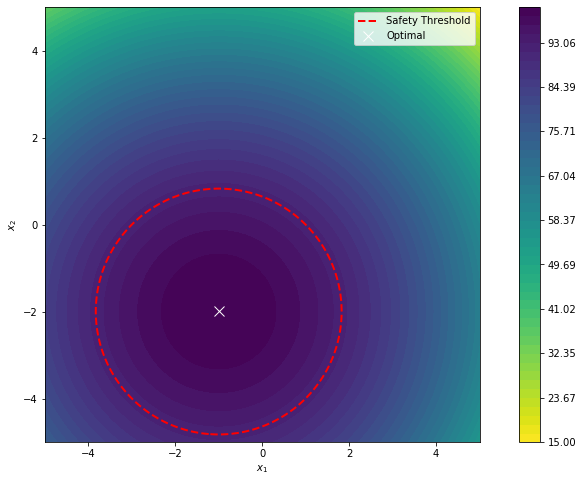

In [26]:
x_opt = fun.get_optimal_x()
y_opt = fun.get_optimal_y()
print(f'y_opt = {y_opt}, x_opt = {x_opt}')

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

Safe seeds:
 X = [[-2.13426854 -4.25851703]
 [-2.41482966 -0.27054108]
 [ 0.33066132 -4.25851703]
 [ 0.95190381 -0.93186373]
 [-3.43687375 -2.43486974]
 [-3.57715431 -2.4749499 ]
 [ 0.87174349 -0.67134269]
 [ 0.63126253 -4.23847695]
 [-1.13226453 -3.81763527]
 [ 0.19038076  0.03006012]]
 y = [[93.61253569]
 [95.00722889]
 [93.12844125]
 [95.04915643]
 [93.87253465]
 [93.13269826]
 [94.73124606]
 [92.3282035 ]
 [96.67870812]
 [94.46184955]]
 idx = [ 18643 118129  18766 101797  64078  63071 108293  19281  29693 125759]
Safe seeds:
 X = [[-2.13426854 -4.25851703]
 [-2.41482966 -0.27054108]
 [ 0.33066132 -4.25851703]
 [ 0.95190381 -0.93186373]
 [-3.43687375 -2.43486974]]
 y = [[93.61253569]
 [95.00722889]
 [93.12844125]
 [95.04915643]
 [93.87253465]]


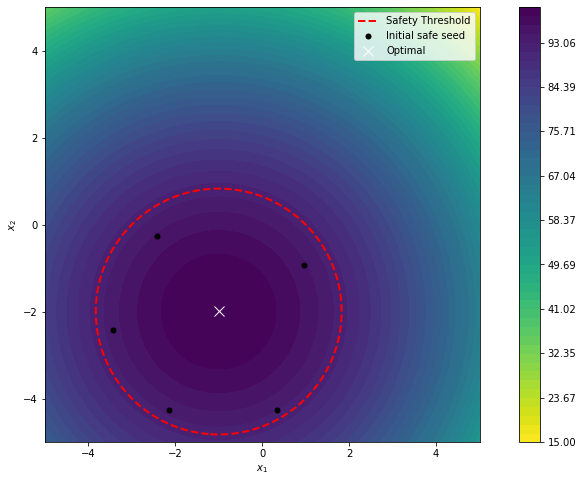

In [27]:
#Random selection (initial safe seed)
from numpy.random import default_rng
random_seed = 42
rng = default_rng(random_seed)
x_safe_seed, y_safe_seed = fun.get_uniform_safe_seeds(rng, n=10)
x_safe_seed, y_safe_seed = fun.get_default_safe_seeds(n=5)

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

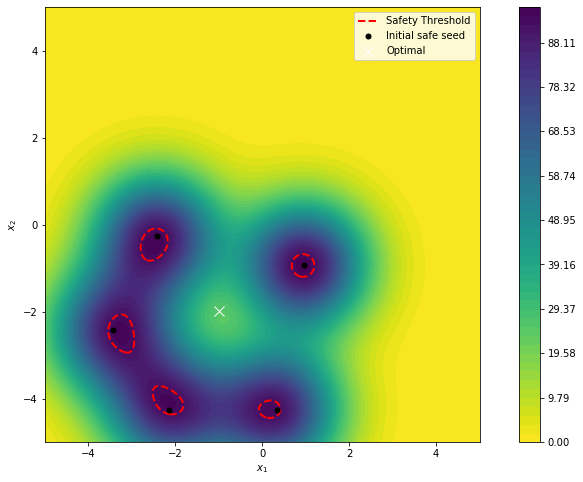

Lipschitz constant = 13.979959919840175


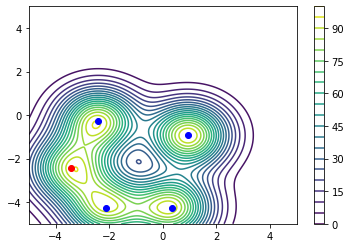

In [29]:
def run_safeopt(opt, fun, iterations, plot=False):
    for i in range(iterations):
        # Obtain next query point
        x_next = opt.optimize()
        # Get a measurement from the real system
        y_meas = fun(x_next)
        # Add this to the GP model
        opt.add_new_data_point(x_next, y_meas)
        print(f'evals={opt.t}\tx_next={x_next}\ty={y_meas}\tsafe={y_meas >= opt.fmin}')
        if plot: opt.plot(500)

def safeopt_stats(opt, fun):
    emax = opt.get_maximum()
    print(f'Estimated maximum = {emax} true_y = {fun(emax[0])}')
    print(f'Max found: {np.max(opt.y)}')
    print(f'Number of failures: {np.sum(opt.y < opt.fmin)} ({fun.n_unsafe})')
    
# Measurement noise, I will add the variance soon
noise_var = 0
# Define Kernel (2-dimensional RBF kernel)
kernel = GPy.kern.RBF(input_dim=fun.xdim, ARD=True)
#kernel = GPy.kern.Matern52(fun.xdim,ARD=True)
# The statistical model of our objective function
gp = GPy.models.GPRegression(x_safe_seed, y_safe_seed, kernel=kernel, noise_var=noise_var)
# The optimization routine
# FIXME: Why beta = 1.96 ?
mean, var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()
opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=fun.safe_threshold, lipschitz=fun.lipschitz, beta = 2, threshold=0)
# here, use lipschitz=None for modified safeopt
#opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=[fun.safe_threshold], lipschitz=None, beta = 1.96)
# Plot initial safe seed
opt.plot(500)

evals=6	x_next=[-2.63527054 -0.75150301]	y=95.76714551347183	safe=[ True]
evals=7	x_next=[-3.03607214 -2.75551102]	y=95.283613318822	safe=[ True]
evals=8	x_next=[-2.5751503  -3.77755511]	y=94.35919936064514	safe=[ True]
evals=9	x_next=[-1.99398798 -3.85771543]	y=95.56088128160128	safe=[ True]
evals=10	x_next=[-3.05611222 -2.0741483 ]	y=95.76690455058413	safe=[ True]
evals=11	x_next=[-0.01002004 -4.17835671]	y=94.27470170802528	safe=[ True]
evals=12	x_next=[-2.23446894 -0.65130261]	y=96.65710177870771	safe=[ True]
evals=13	x_next=[ 0.75150301 -1.09218437]	y=96.10810799956627	safe=[ True]
evals=14	x_next=[ 0.63126253 -0.81162325]	y=95.92674326609131	safe=[ True]
evals=15	x_next=[ 0.0501002  -4.43887776]	y=92.94916486279172	safe=[ True]


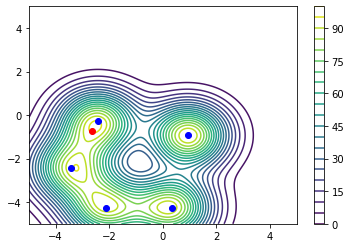

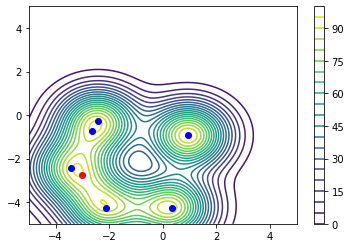

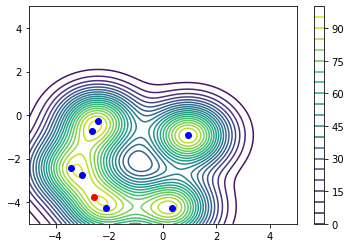

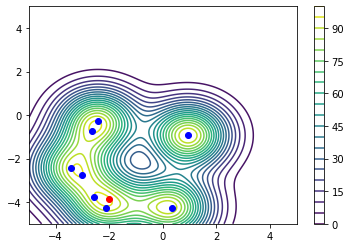

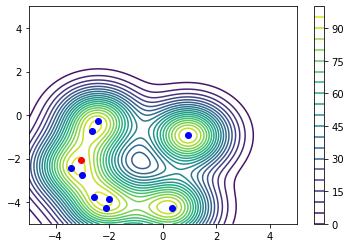

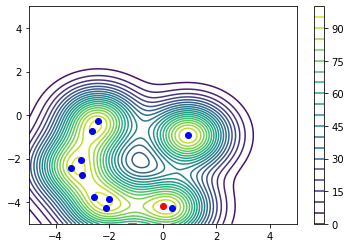

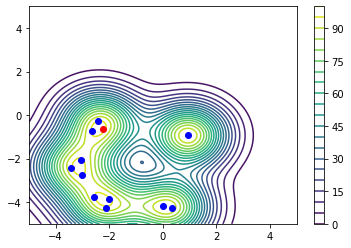

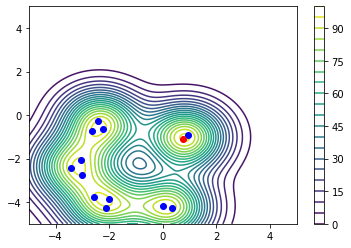

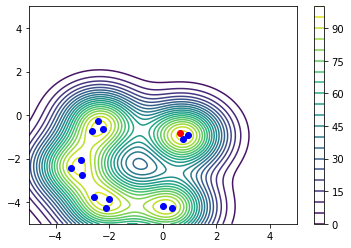

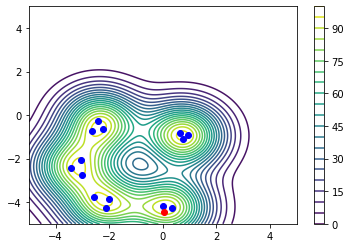

In [30]:
# do 10 iterations
run_safeopt(opt, fun, 10, plot=True)

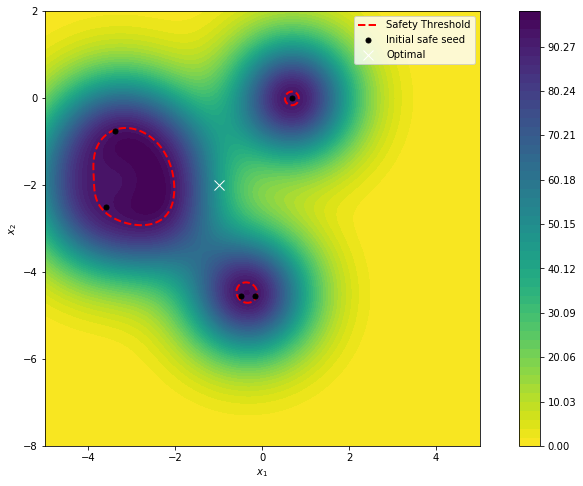

In [19]:
mean,  var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

Estimated maximum = (array([-2.53507014, -2.20841683]), 98.24741067663366) true_y = 97.6001220878631
Max found: 97.99594379139039
Number of failures: 2 (2)


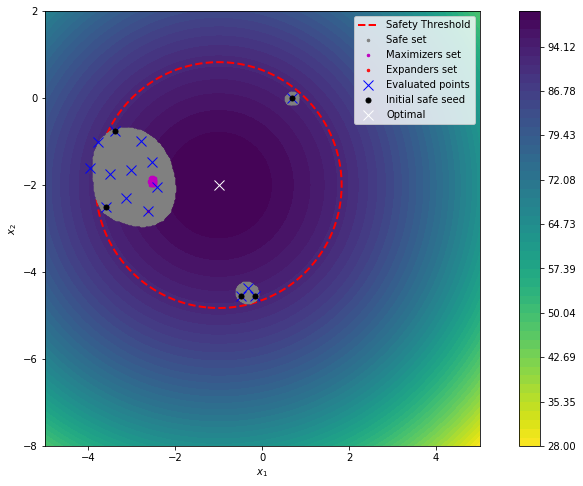

In [20]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

evals=12	x_next=[-2.91583166  2.        ]	y=-19.670410962204972	safe=[False]
evals=13	x_next=[-1.89378758 -1.44689379]	y=-1.1047827117160178	safe=[ True]
evals=14	x_next=[-2.19438878 -7.07815631]	y=-27.21423608740528	safe=[False]
evals=15	x_next=[2.65531062 0.57715431]	y=-20.00302006819249	safe=[False]
evals=16	x_next=[ 5.         -5.69539078]	y=-49.65591302846174	safe=[False]
evals=17	x_next=[-5.  2.]	y=-32.0	safe=[False]
evals=18	x_next=[-2.41482966 -3.59118236]	y=-4.533604282713725	safe=[ True]
evals=19	x_next=[-1.15230461  0.51703407]	y=-6.358657194147814	safe=[ True]
evals=20	x_next=[ 1.21242485 -5.93587174]	y=-20.3859100967466	safe=[False]
evals=21	x_next=[ 3.05611222 -2.72945892]	y=-16.984156690133773	safe=[False]
evals=22	x_next=[-4.05811623 -2.20841683]	y=-9.395512467821415	safe=[False]
evals=23	x_next=[ 1.17234469 -3.57114228]	y=-7.187569527833221	safe=[ True]
evals=24	x_next=[-3.19639279  0.05611222]	y=-9.051738748037156	safe=[False]
evals=25	x_next=[-0.39078156 -2.46893788]

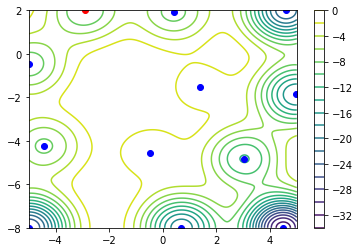

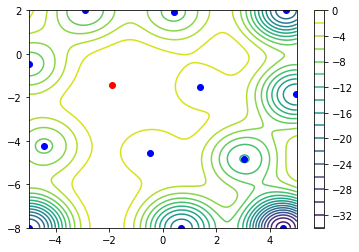

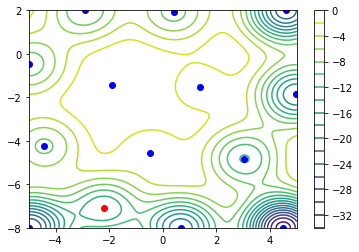

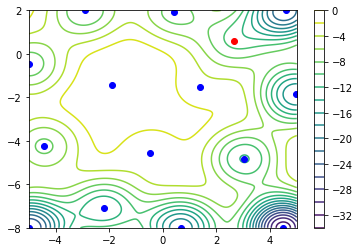

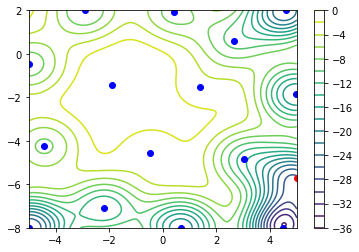

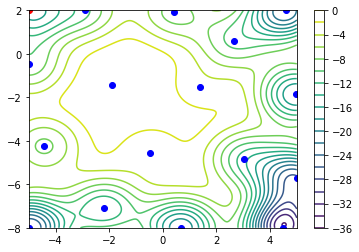

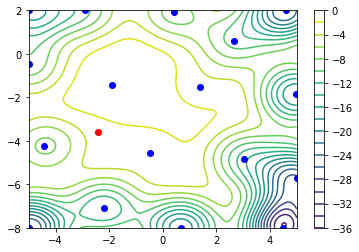

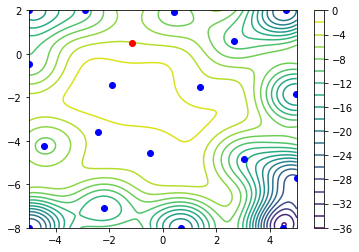

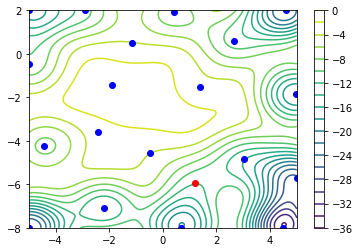

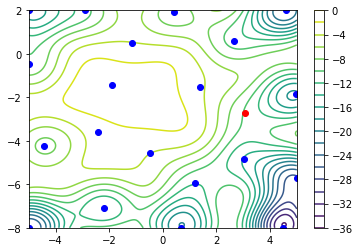

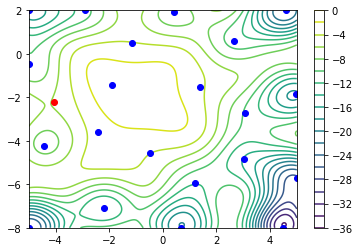

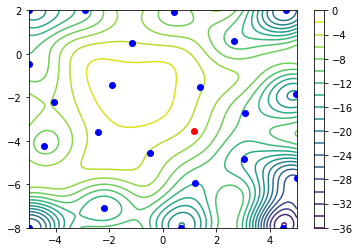

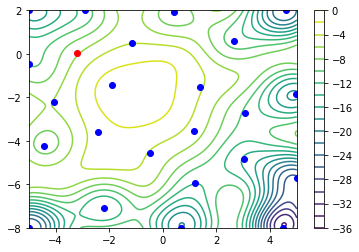

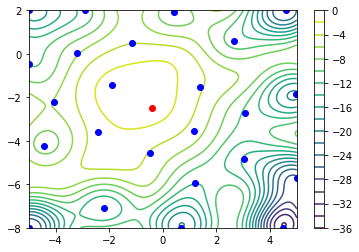

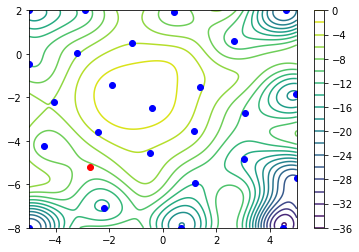

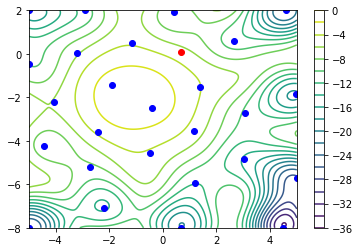

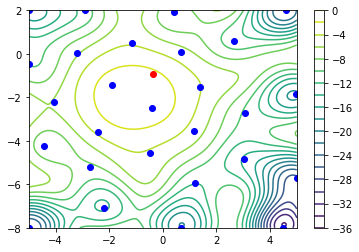

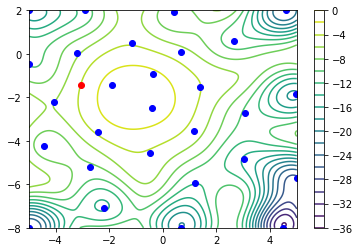

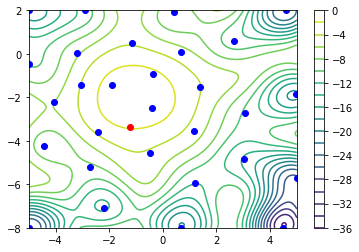

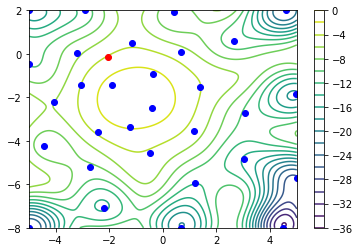

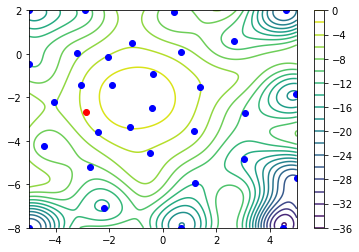

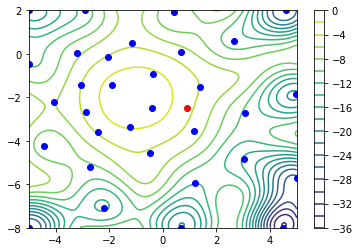

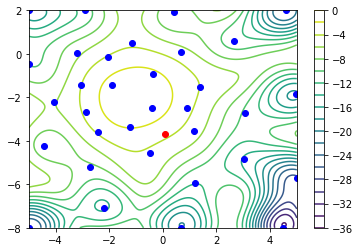

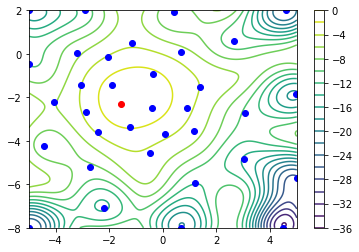

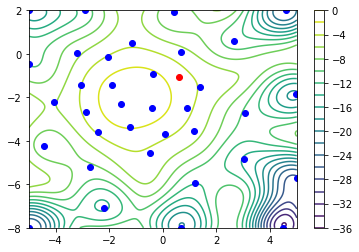

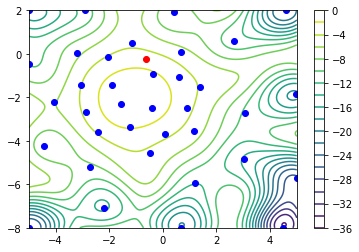

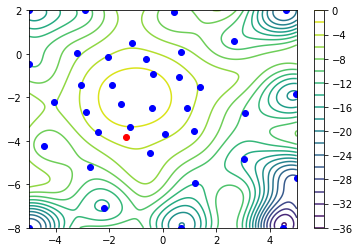

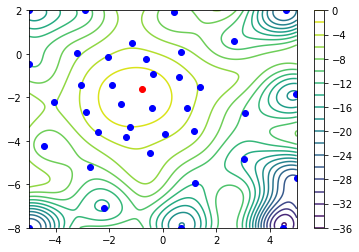

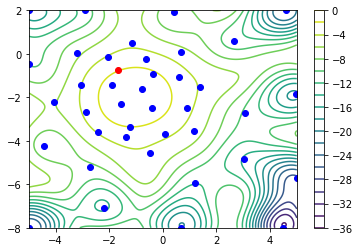

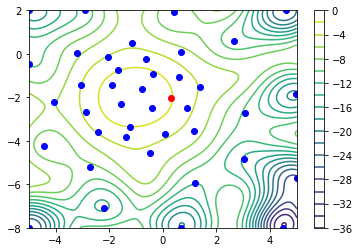

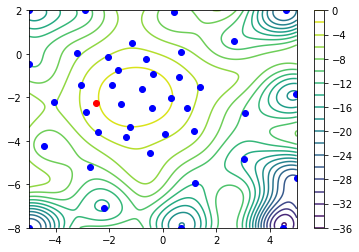

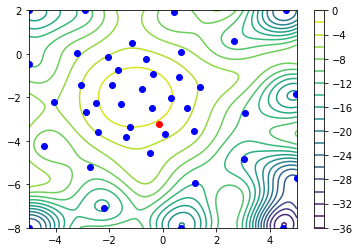

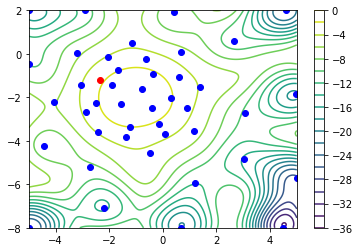

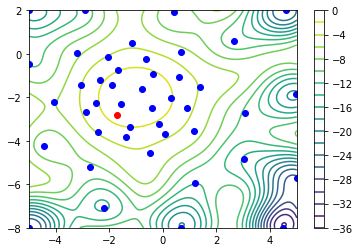

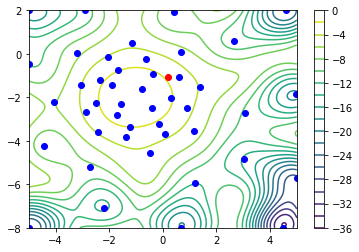

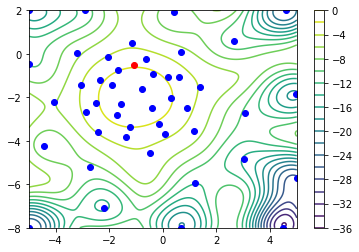

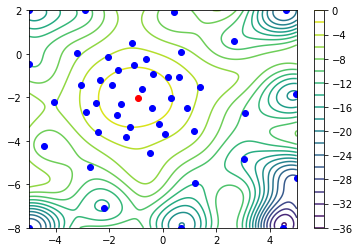

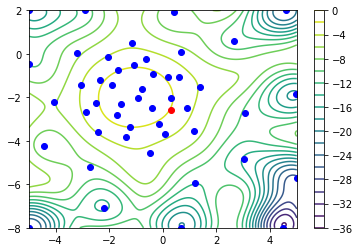

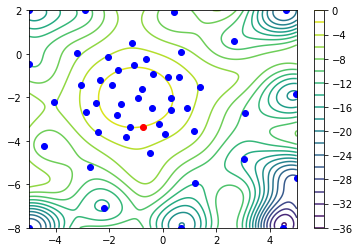

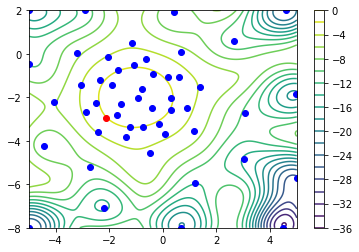

In [7]:
# do 40 more iterations (so far, 50 iterations)
run_safeopt(opt, fun, 40, plot=True)

Estimated maximum = (array([-0.99198397, -2.00801603]), -1.0697473893247096) true_y = -0.0001285135401062649
Max found: -0.004706808406391868
Number of failures: 19 (19)


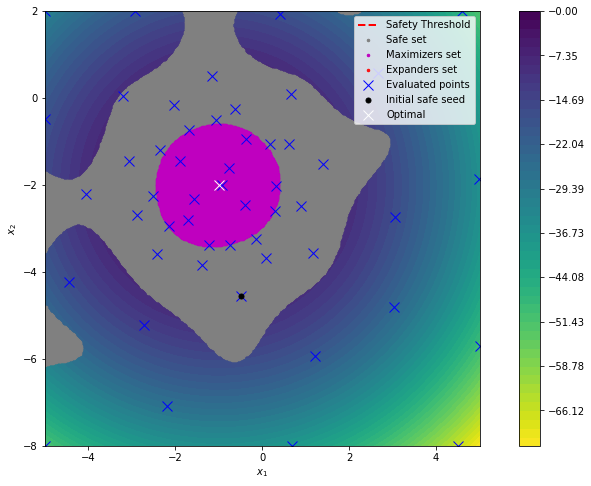

In [8]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

In [9]:
#do 60 iterations (so far 100 iterations)
run_safeopt(opt, fun, 60, plot=False) # This is very slow!

evals=52	x_next=[-1.31262525 -1.34669339]	y=-0.5245440781362319	safe=[ True]
evals=53	x_next=[ 0.33066132 -1.68737475]	y=-1.8683941028349271	safe=[ True]
evals=54	x_next=[-2.3747495  -1.82765531]	y=-1.919638876952302	safe=[ True]
evals=55	x_next=[-0.83166333 -2.62925852]	y=-0.42430351685334583	safe=[ True]
evals=56	x_next=[-0.41082164 -0.80561122]	y=-1.7736956879691237	safe=[ True]
evals=57	x_next=[-1.75350701 -0.90581162]	y=-1.7650210240119513	safe=[ True]
evals=58	x_next=[ 0.09018036 -2.72945892]	y=-1.7206035317127248	safe=[ True]
evals=59	x_next=[-1.55310621 -3.23046092]	y=-1.8199605624073802	safe=[ True]
evals=60	x_next=[-0.41082164 -1.70741483]	y=-0.4327372179228187	safe=[ True]
evals=61	x_next=[-1.73346693 -2.08817635]	y=-0.5457488122537663	safe=[ True]
evals=62	x_next=[-0.65130261 -3.19038076]	y=-1.5385962305372283	safe=[ True]
evals=63	x_next=[-1.09218437 -0.74549098]	y=-1.582290834173356	safe=[ True]
evals=64	x_next=[-2.23446894 -2.30861723]	y=-1.6191581559913415	safe=[ True]


Estimated maximum = (array([-0.99198397, -1.98797595]), -0.5163877146109319) true_y = -0.00020883450267266798
Max found: -0.004706808406391868
Number of failures: 19 (19)


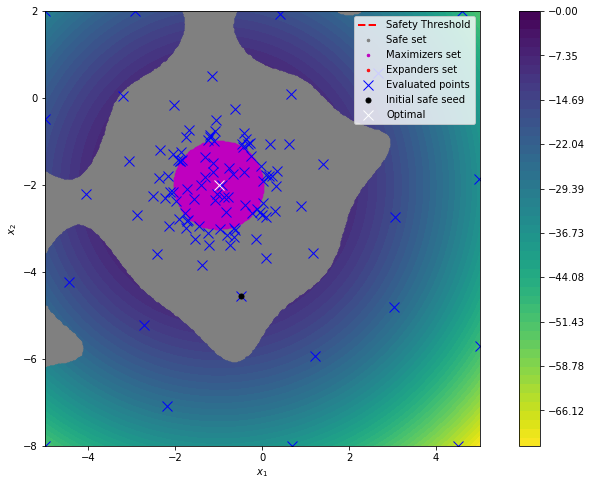

In [10]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)